In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../Datasets/diabetes_prediction_dataset.csv')

In [3]:
data = data.drop_duplicates()
data = data.dropna()

In [4]:
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

In [5]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

data['smoking_history'] = data['smoking_history'].apply(recategorize_smoking)

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

X = data.drop('diabetes', axis=1)
y = data['diabetes']

In [7]:
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [8]:
param_grid = {
    'classifier__n_estimators': [200],
    'classifier__max_depth': [30],
    'classifier__min_samples_split': [5],
    'classifier__min_samples_leaf': [1]
}

In [9]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


Model Accuracy:  0.9383255330213208
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     17509
           1       0.62      0.83      0.71      1721

    accuracy                           0.94     19230
   macro avg       0.80      0.89      0.84     19230
weighted avg       0.95      0.94      0.94     19230



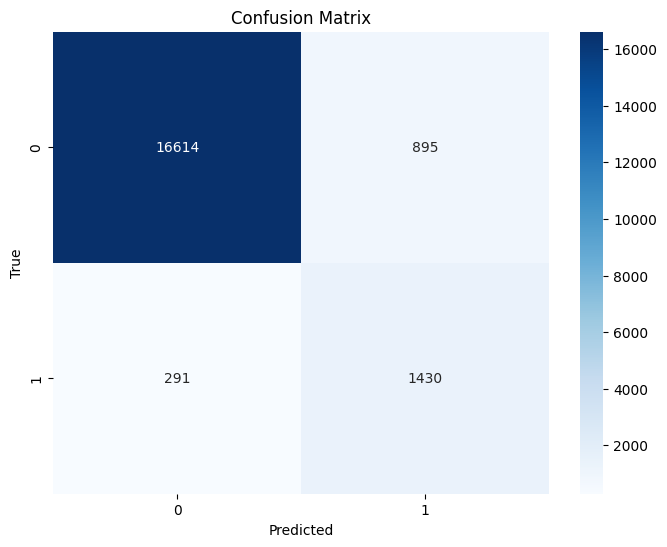

In [ ]:
y_pred = grid_search.predict(X_test)

print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()